In [1]:
import json
import matplotlib.pyplot as plt
from arsenic import stats, plotting
import networkx as nx
import numpy as np

In [2]:
import diffnet

In [3]:
results = json.load(open('/Users/brucemah/Desktop/Sprint3/2020-08-20-benzotriazoles/analysis.json','r'))

In [4]:
result_graphs = diffnet.combine_relative_free_energies(results)

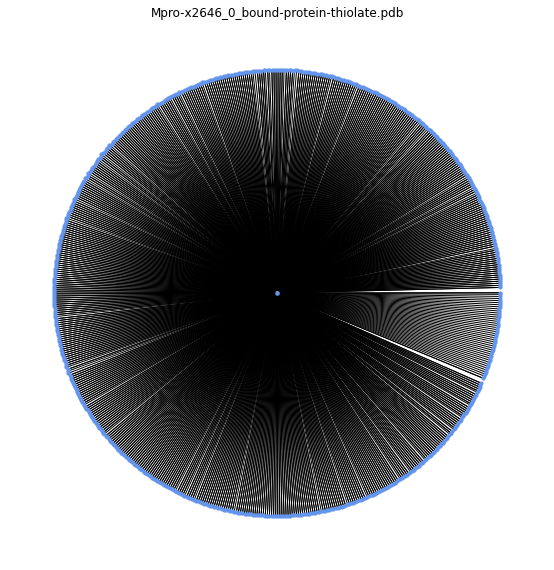

In [5]:
for protein, graph in result_graphs.items():
    plt.figure(figsize=(7.5,7.5))
    nx.draw_kamada_kawai(graph,node_color='cornflowerblue',node_size=10)
    plt.title(protein)
    plt.show()

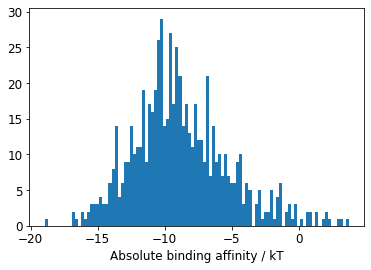

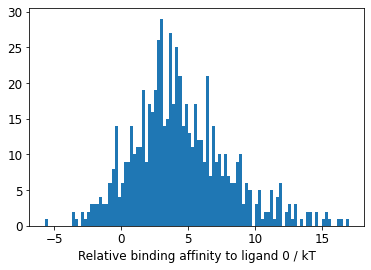

In [12]:
plt.hist([n[1]['f_i'] for n in graph.nodes(data=True)],bins=100)
plt.xlabel('Absolute binding affinity / kT')
plt.show()


# relative to experimental
plt.hist([n[1]['f_i']--13.24 for n in graph.nodes(data=True)],bins=100)
plt.xlabel('Relative binding affinity to ligand 0 / kT')
plt.show()

In [13]:
nodes_to_keep = []
has_expt = []
for protein, graph in result_graphs.items():
    for node in graph.nodes(data=True):
        if 'exp_DG' in node[1]:
            nodes_to_keep.append(node[0])
            has_expt.append(node[0])
        # find another way to filter down to the best compounds!!!
        elif node[1]['f_i'] < -13.24:
            nodes_to_keep.append(node[0])
            
print(len(nodes_to_keep))

small_graph = diffnet.reduce_graph(graph, nodes_to_keep)

61


In [14]:
from pyvis.network import Network

got_net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

got_net.from_nx(small_graph)


for node in got_net.nodes:
    if node['title'] in has_expt: # if it has an experimental affinity, colour it differently
        node['color'] = 'bisque' 
        print(node)
    node['size'] = 5
    node['label'] = ''
    node['title'] = node['title'] + '<br>DG '+f"{graph.nodes()[node['title']]['f_i']:.1f}"
# TODO: have an image of each ligand on disk, and use the path to that instead of a node
#   node['shape']='imageCircular'
#   node['image'] = "img_lights.jpg"

got_net.show("netowrk.html")

{'title': 'ALP-POS-d2866bdf-1', 'id': 'ALP-POS-d2866bdf-1', 'label': 'ALP-POS-d2866bdf-1', 'shape': 'dot', 'font': {'color': 'white'}, 'color': 'bisque'}
{'title': 'ALP-POS-c59291d4-2', 'id': 'ALP-POS-c59291d4-2', 'label': 'ALP-POS-c59291d4-2', 'shape': 'dot', 'font': {'color': 'white'}, 'color': 'bisque'}


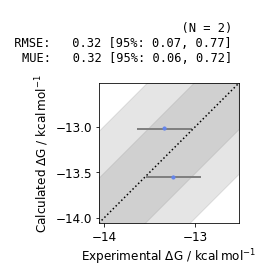

In [15]:
x = []
y = []
xerr = []
yerr = []

for node in graph.nodes(data=True):
    if 'exp_DG' in node[1]:
        x.append(node[1]['exp_DG'])
        y.append(node[1]['f_i'])
        yerr.append(node[1]['df_i'])
        xerr.append(0.3) # do something better than this

plotting._master_plot(np.asarray(x), np.asarray(y), xerr=np.asarray(xerr), yerr=np.asarray(yerr),quantity='$\\Delta$G')
plt.show()

In [16]:
ligands = set([result['details']['ligand'] for result in results])

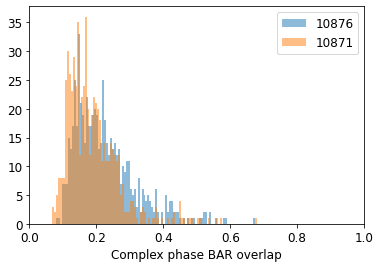

In [17]:
for lig in ligands:
    plt.hist([result['analysis']['complex_phase']['free_energy']['bar_overlap'] for result in results if result['details']['ligand'] == lig],
            alpha=0.5,label=lig.split('-')[-1][1:-4],bins=100)

plt.legend()    
plt.xlim(0.,1.)
plt.xlabel('Complex phase BAR overlap')
plt.show()

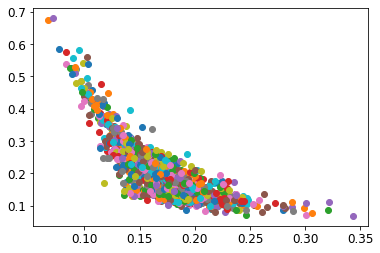

In [23]:
for edge in graph.edges(data=True):
    plt.scatter(float(edge[2]['f_dij']), float(edge[2]['complex_overlap']))
plt.show()

In [ ]:
0.5 log pIC50 error